<h1 align="center"> Image Captioning </h1>

In this notebook you will teach a network to do image captioning
![img](https://media.licdn.com/dms/image/C4D12AQH-T7BYWr9clg/article-inline_image-shrink_1500_2232/0?e=2120536800&v=alpha&t=RrGrsyl8QPtDQjdKKw6VpEbJrTq1Dnigk89_t9vhbfw)



#### Alright, here's our plan:
1. Take a pre-trained inception v3 to vectorize images
2. Stack an LSTM on top of it
3. Train the thing on [MSCOCO](http://cocodataset.org/#download)

In [1]:
# Please eithrer download data from https://yadi.sk/d/b4nAwIE73TVcp5 or generate it manually.

### Data preprocessing

In [92]:
%%time
# Read Dataset
import numpy as np
import json
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline
img_codes = np.load("data/image_codes.npy")
captions = json.load(open('data/captions_tokenized.json'))

CPU times: user 140 ms, sys: 308 ms, total: 448 ms
Wall time: 446 ms


### Data structure

To save your time, we've already vectorized all MSCOCO17 images with a pre-trained inception_v3 network from [torchvision](https://github.com/pytorch/vision/blob/master/torchvision/models/inception.py).

The whole process takes anywhere between a day on CPU and 10min on 3x tesla m40. If you want to play with that yourself, [you're welcome](https://gist.github.com/justheuristic/11fd01f9c12c0bf960499580d104130b).

In [93]:
print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0,:10], end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 2048-unit vector [ shape: (118287, 2048) ]
[0.3659946  0.2016555  0.9245725  0.57063824 0.547268   0.8275868
 0.3687277  0.12085301 0.0561931  0.49758485]

For each image there are 5 reference captions, e.g.:

people shopping in an open market for vegetables .
an open market full of people and piles of vegetables .
people are shopping at an open air produce market .
large piles of carrots and potatoes at a crowded outdoor market .
people shop for vegetables like carrots and potatoes at an open air market .


As you can see, all captions are already tokenized and lowercased. We now want to split them and add some special tokens for start/end of caption.

In [94]:
#split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i] 
        captions[img_i][caption_i] = ["#START#"]+sentence.split(' ')+["#END#"]

You don't want your network to predict a million-size vector of probabilities at each step, so we're gotta make some cuts. 

We want you to __count the occurences of each word__ so that we can decide which words to keep in our vocabulary.

In [95]:
# Build a Vocabulary
from collections import Counter
word_counts = Counter()

#Compute word frequencies for each word in captions. See code above for data structure
#<YOUR CODE HERE>
tmp = [];
for i in range(len(captions)):
    for j in range(len(captions[i])):
        for k in range(len(captions[i][j])):
            tmp.append(captions[i][j][k]);
word_counts = Counter(tmp);
del tmp

In [96]:
vocab  = ['#UNK#', '#START#', '#END#', '#PAD#']
vocab += [k for k, v in word_counts.items() if v >= 5 if k not in vocab]
n_tokens = len(vocab)

assert 10000 <= n_tokens <= 10500

word_to_index = {w: i for i, w in enumerate(vocab)}

In [97]:
eos_ix = word_to_index['#END#']
unk_ix = word_to_index['#UNK#']
pad_ix = word_to_index['#PAD#']

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences), max_len), dtype='int32') + pad_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word, unk_ix) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [98]:
#try it out on several descriptions of a random image
as_matrix(captions[1337])

array([[   1,   24,  262,  140,    6,  159,   14,   24,  858,  155,   12,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   53,   18,   24,  858,  155,    2,    3,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   41,   18,  903,   35,  620,  155,    2,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   45,  115,  262,   41,   53,   18,  620, 1525,   77,   12,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   53,   18,   24,  858,  123,   58,   45,  276,
        3641,   24, 3642,   35,   45, 1128,   12,    2]], dtype=int32)

### Building our neural network

As we mentioned earlier, we shall build an rnn "language-model" conditioned on vectors from the convolutional part. 

![img](https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/model.png)
_image: http://bit.ly/2FKnqHm_


We'll unbox the inception net later to save memory, for now just pretend that it's available.


In [99]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [100]:
class CaptionNet(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=128, lstm_units=256, cnn_feature_size=2048):
        """ A recurrent 'head' network for image captioning. See scheme above. """
        super(self.__class__, self).__init__()
        
        # a layer that converts conv features to 
        self.cnn_to_h0 = nn.Linear(cnn_feature_size, lstm_units)
        self.cnn_to_c0 = nn.Linear(cnn_feature_size, lstm_units)
        
        # recurrent part, please create the layers as per scheme above.

        # create embedding for input words. Use the parameters (e.g. emb_size).
        self.emb = nn.Embedding(n_tokens, emb_size);
            
        # lstm: create a recurrent core of your network. Use either LSTMCell or just LSTM. 
        # In the latter case (nn.LSTM), make sure batch_first=True
        self.lstm = nn.LSTM(emb_size,lstm_units,batch_first=True);
            
        # create logits: linear layer that takes lstm hidden state as input and computes one number per token
        self.logits = nn.Linear(lstm_units,n_tokens);
        
    def forward(self, image_vectors, captions_ix):
        """ 
        Apply the network in training mode. 
        :param image_vectors: a Variable containing inception vectors. shape: [batch, cnn_feature_size]
        :param captions_ix: a Variable containing captions as matrix. shape: [batch, word_i]. 
            padded with pad_ix
        :returns: logits for next token at each tick, shape: [batch, word_i, n_tokens]
        """
        initial_cell = self.cnn_to_c0(image_vectors)
        initial_hid = self.cnn_to_h0(image_vectors)
        
        # compute embeddings for captions_ix
        captions_emb = self.emb(captions_ix);
        
        # apply recurrent layer to captions_emb.
        # 1. initialize lstm state with initial_* from above
        # 2. feed it with captions. Mind the dimension order in docstring
        # 3. compute logits for next token probabilities
        # Note: if you used nn.LSTM, you can just give it (initial_cell[None], initial_hid[None]) as second arg

        # lstm_out should be lstm hidden state sequence of shape [batch, caption_length, lstm_units]
        lstm_out = self.lstm(captions_emb, (initial_cell[None], initial_hid[None]))[0];
        
        # compute logits from lstm_out
        logits = self.logits(lstm_out);
        
        return logits        

In [101]:
network = CaptionNet(n_tokens).cuda()

In [102]:
dummy_img_vec = Variable(torch.randn(len(captions[0]), 2048)).cuda()
dummy_capt_ix = Variable(torch.LongTensor(as_matrix(captions[0]))).cuda()

dummy_logits = network.forward(dummy_img_vec, dummy_capt_ix)

print('shape:', dummy_logits.shape)
assert dummy_logits.shape == (dummy_capt_ix.shape[0], dummy_capt_ix.shape[1], n_tokens)

shape: torch.Size([5, 16, 10403])


In [103]:
def compute_loss(network, image_vectors, captions_ix):
    """
    :param image_vectors: a Variable containing inception vectors. shape: [batch, cnn_feature_size]
    :param captions_ix: a Variable containing captions as matrix. shape: [batch, word_i]. 
        padded with pad_ix
    :returns: crossentropy (neg llh) loss for next captions_ix given previous ones. Scalar float Variable
    """
    
    # captions for input - all except last cuz we don't know next token for last one.
    captions_ix_inp = captions_ix[:, :-1].contiguous()
    captions_ix_next = captions_ix[:, 1:].contiguous()
    
    # apply the network, get predictions for captions_ix_next
    logits_for_next = network.forward(image_vectors, captions_ix_inp)
    
    # compute the loss function between logits_for_next and captions_ix_next
    # Use the mask, Luke: make sure that predicting next tokens after EOS do not contribute to loss
    # you can do that either by multiplying elementwise loss by (captions_ix_next == pad_ix)
    # or by using ignore_index in some losses.
    #print("logits_for_next")
    #print(logits_for_next)
    #print("captions_ix_next")
    #print(captions_ix_next)
    #loss = 0;
    #n = captions_ix_next.size()[0]*captions_ix_next.size()[1];
    #print(n);
    #print(n_tokens)
    loss = F.cross_entropy(logits_for_next.view(-1,n_tokens),captions_ix_next.view(-1));
    return torch.mean(loss[captions_ix_next.view(-1) != pad_ix]);

In [104]:

dummy_loss = compute_loss(network, dummy_img_vec, dummy_capt_ix)

assert dummy_loss.shape == torch.Size([1]), 'loss must be scalar'
assert dummy_loss.data.cpu().numpy() > 0, "did you forget the 'negative' part of negative log-likelihood"

dummy_loss.backward()

assert all(param.grad is not None for param in network.parameters()), \
        'loss should depend differentiably on all neural network weights'

Create ~~adam~~ your favorite optimizer for the network.

In [105]:
opt = torch.optim.Adam(network.parameters(),lr=0.01);

# Training

* First implement the batch generator
* Than train the network as usual

In [106]:
from sklearn.model_selection import train_test_split
captions = np.array(captions)
train_img_codes, val_img_codes, train_captions, val_captions = train_test_split(img_codes, captions,
                                                                                test_size=0.1,
                                                                                random_state=42)

In [107]:
from random import choice


def generate_batch(img_codes, captions, batch_size, max_caption_len=None):
    
    #sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0, len(img_codes), size=batch_size)
    
    #get images
    batch_images = img_codes[random_image_ix]
    
    #5-7 captions for each image
    captions_for_batch_images = captions[random_image_ix]
    
    #pick one from a set of captions for each image
    batch_captions = list(map(choice,captions_for_batch_images))
    
    #convert to matrix
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)
    
    return Variable(torch.FloatTensor(batch_images)).cuda(), Variable(torch.LongTensor(batch_captions_ix)).cuda()
    

In [108]:
generate_batch(img_codes,captions,3)

(Variable containing:
  0.3512  0.4258  0.3390  ...   0.0908  1.2009  0.1933
  0.7149  0.1761  0.5797  ...   0.0688  0.6032  1.0749
  0.5543  0.6904  0.1924  ...   0.0816  0.3079  0.0080
 [torch.cuda.FloatTensor of size 3x2048 (GPU 0)], Variable containing:
 
 Columns 0 to 12 
     1    24   102    14    24    29    63    41    35   620   617   612    12
     1   370  1314   174   140     6    24  3261    18   903    12     2     3
     1    24   500  1916   183    45  1359    35    24  1027   250    12     2
 
 Columns 13 to 13 
     2
     3
     3
 [torch.cuda.LongTensor of size 3x14 (GPU 0)])

### Main loop

Train on minibatches just as usual. Evaluate on val from time to time.

##### TIps
* If training loss has become close to 0 or model produces garbage,
    double-check that you're predicting __next__ words, not current or t+2'th words.
* If the model generates fluent captions that have nothing to do with the images
 * this may be due to recurrent net not receiving image vectors.
 * alternatively it may be caused by gradient explosion, try clipping 'em or just restarting the training
 * finally, you may just need to train the model a bit more


* Crossentropy is a poor measure of overfitting
 * Model can overfit validation crossentropy but keep improving validation quality.
 * Use human _(manual)_ evaluation or try automated metrics: [cider](https://github.com/vrama91/cider) or [bleu](https://www.nltk.org/_modules/nltk/translate/bleu_score.html)
 

* We recommend you to periodically evaluate the network using the next "apply trained model" block
 *  its safe to interrupt training, run a few examples and start training again
 
* The typical loss values should be around 3~5 if you average over time, scale by length if you sum over time. The reasonable captions began appearing at loss=2.8 ~ 3.0
 

In [109]:
batch_size = 100  # adjust me
n_epochs = 10  # adjust me
n_batches_per_epoch = 1000  # adjust me
n_validation_batches = 5  # how many batches are used for validation after each epoch

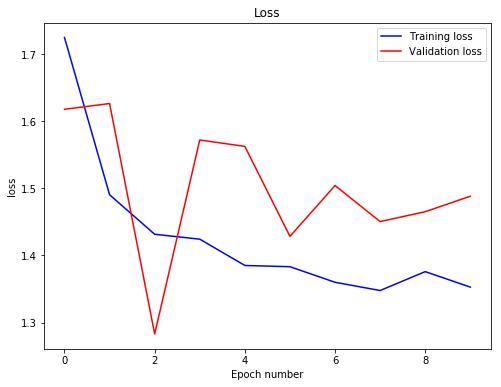


Epoch: 9, train loss: 1.3528173313736915, val loss: 1.4883499622344971
Finished!


In [110]:
from tqdm import tqdm
train_loss_plot = [];
val_loss_plot = [];
for epoch in range(n_epochs):
    
    train_loss=0
    network.train(True)
    for _ in tqdm(range(n_batches_per_epoch)):
        
        loss_t = compute_loss(network, *generate_batch(train_img_codes, train_captions, batch_size))
        
        
        # clear old gradients; do a backward pass to get new gradients; then train with opt
        #<YOUR CODE>
        opt.zero_grad()
        loss_t.backward()
        opt.step()
        train_loss += loss_t.data.cpu().numpy()[0]
        
    train_loss /= n_batches_per_epoch
    train_loss_plot.append(train_loss);
    val_loss=0
    network.train(False)
    for _ in range(n_validation_batches):
        loss_t = compute_loss(network, *generate_batch(val_img_codes, val_captions, batch_size))
        val_loss += loss_t.data.cpu().numpy()[0]
    val_loss /= n_validation_batches
    val_loss_plot.append(val_loss);
    display.clear_output(wait=True);
    plt.figure(figsize=(8,6));
    plt.title("Loss");
    plt.xlabel("Epoch number");
    plt.ylabel("loss");
    plt.plot(train_loss_plot,'b',label="Training loss");
    plt.plot(val_loss_plot,'r',label="Validation loss");
    plt.legend()
    plt.show();
    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

print("Finished!")

### Apply trained model

Let's unpack our pre-trained inception network and see what our model is capable of.

In [111]:
from beheaded_inception3 import beheaded_inception_v3
inception = beheaded_inception_v3().train(False).cuda()

### Generate caption

The function below creates captions by sampling from probabilities defined by the net.

The implementation used here is simple but inefficient (quadratic in lstm steps). We keep it that way since it isn't a performance bottleneck.

In [112]:
def generate_caption(image, caption_prefix = ("START",), 
                     t=1, sample=True, max_len=100):
    
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3
    
    image = Variable(torch.FloatTensor(image.transpose([2, 0, 1])), volatile=True).cuda()
    
    vectors_8x8, vectors_neck, logits = inception(image[None])
    caption_prefix = list(caption_prefix)
    
    for _ in range(max_len):
        
        prefix_ix = as_matrix([caption_prefix])
        prefix_ix = Variable(torch.LongTensor(prefix_ix), volatile=True).cuda()
        next_word_logits = network.forward(vectors_neck, prefix_ix)[0, -1]
        next_word_probs = F.softmax(next_word_logits, -1).data.cpu().numpy()
        
        
        assert len(next_word_probs.shape) ==1, 'probs must be one-dimensional'
        next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t) # apply temperature

        if sample:
            next_word = np.random.choice(vocab, p=next_word_probs) 
        else:
            next_word = vocab[np.argmax(next_word_probs)]

        caption_prefix.append(next_word)

        if next_word=="#END#":
            break
            
    return caption_prefix

In [113]:
from matplotlib import pyplot as plt
from scipy.misc import imresize
%matplotlib inline

#sample image
!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

--2018-04-25 19:25:43--  https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg
Resolving pixel.nymag.com (pixel.nymag.com)... 151.101.112.70
Connecting to pixel.nymag.com (pixel.nymag.com)|151.101.112.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 107928 (105K) [image/jpeg]
Saving to: ‘data/img.jpg’

100%[======================================>] 107 928     --.-K/s   in 0,1s    

2018-04-25 19:25:43 (750 KB/s) - ‘data/img.jpg’ saved [107928/107928]



/home/use/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


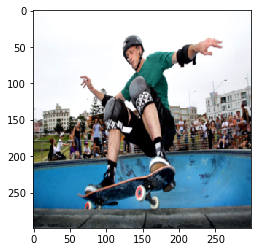

In [114]:
plt.imshow(img)

In [115]:
for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

a man riding a skateboard on a ramp .
a man riding a skateboard down a street .
a man riding a skateboard on a ramp .
a man riding a skateboard on a rail .
a man riding a skateboard on a ramp .
a man riding a skateboard on a rail .
a man riding a skateboard down a street .
a man riding a skateboard on a rail .
a man riding a skateboard down a street .
a skateboarder jumps into the air while doing tricks .


--2018-04-25 19:41:41--  http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Resolving ccanimalclinic.com (ccanimalclinic.com)... 64.207.177.234
Connecting to ccanimalclinic.com (ccanimalclinic.com)|64.207.177.234|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106870 (104K) [image/jpeg]
Saving to: ‘data/img.jpg’

100%[======================================>] 106 870      124KB/s   in 0,8s   

2018-04-25 19:41:43 (124 KB/s) - ‘data/img.jpg’ saved [106870/106870]



/home/use/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


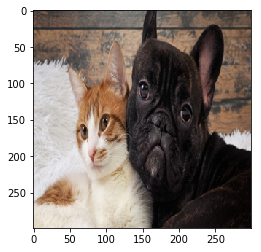

a cat is sitting on a bed with a dog .
a cat laying on a bed with a white dog .
a cat is sitting on a chair with a dog .
a cat laying on a bed with a person in the background .
a cat laying on a bed with a white dog .
a cat is sitting on a keyboard on a table .
a cat laying on a bed with a white dog .
a cat laying on a bed looking at the camera .
a cat laying on a bed with a dog in the background .
a cat is laying on a bed with a heart .


In [147]:
!wget http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=4.)[1:-1]))

# Demo
### Find at least 10 images to test it on.
* Seriously, that's part of an assignment. Go get at least 10 pictures to get captioned
* Make sure it works okay on __simple__ images before going to something more comples
* Photos, not animation/3d/drawings, unless you want to train CNN network on anime
* Mind the aspect ratio

--2018-04-25 19:31:16--  https://talksport.com/sites/default/files/styles/just_scale/public/field/image/201705/gettyimages-631758630.jpg
Resolving talksport.com (talksport.com)... 89.185.136.132, 89.185.136.133
Connecting to talksport.com (talksport.com)|89.185.136.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38251 (37K) [image/jpeg]
Saving to: ‘data/img.jpg’

100%[======================================>] 38 251      --.-K/s   in 0,06s   

2018-04-25 19:31:17 (659 KB/s) - ‘data/img.jpg’ saved [38251/38251]



/home/use/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


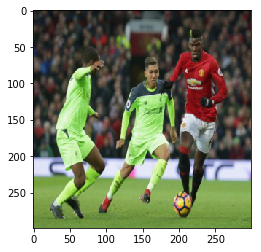

a man is playing a game of frisbee .
a man in a field playing soccer on a field .
a man in a field playing soccer on a field .
a man playing a game of frisbee on a field .
a man is playing a game of soccer on a field .
a man is playing a game of frisbee .
a man in a field playing soccer on a field .
a man is playing a game of soccer .
a man is playing a game of soccer on a field .
a man in a white t-shirt and shorts playing a game of soccer .


In [122]:
!wget https://talksport.com/sites/default/files/styles/just_scale/public/field/image/201705/gettyimages-631758630.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

--2018-04-25 19:36:12--  http://ak5.picdn.net/shutterstock/videos/20830105/thumb/1.jpg
Resolving ak5.picdn.net (ak5.picdn.net)... 2.23.110.206
Connecting to ak5.picdn.net (ak5.picdn.net)|2.23.110.206|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47962 (47K) [image/jpeg]
Saving to: ‘data/img.jpg’

100%[======================================>] 47 962      --.-K/s   in 0,03s   

2018-04-25 19:36:12 (1,68 MB/s) - ‘data/img.jpg’ saved [47962/47962]



/home/use/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


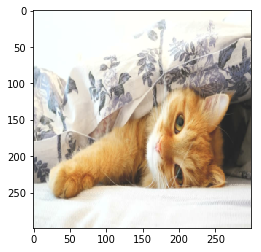

a cat laying on a bed with a blanket .
a cat laying on a bed with a blanket .
a cat laying on a bed with a blanket .
a cat laying on a bed with a blanket .
a cat is laying on a bed with a blanket .
a cat laying on a bed with a blanket .
a cat laying on a bed with a blanket .
a cat laying on a bed with a blanket .
a cat is laying on a bed with a blanket .
a cat is laying on a bed with a blanket .


In [128]:
!wget http://ak5.picdn.net/shutterstock/videos/20830105/thumb/1.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

--2018-04-25 19:48:38--  https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRddIEvpum69uxIXvk-muy94b4EYLCNZHHCQF0rNFzKlYPPVIa4
Resolving encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)... 74.125.131.113, 74.125.131.138, 74.125.131.102, ...
Connecting to encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)|74.125.131.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10527 (10K) [image/jpeg]
Saving to: ‘data/img.jpg’

100%[======================================>] 10 527      --.-K/s   in 0,004s  

2018-04-25 19:48:38 (2,30 MB/s) - ‘data/img.jpg’ saved [10527/10527]



/home/use/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


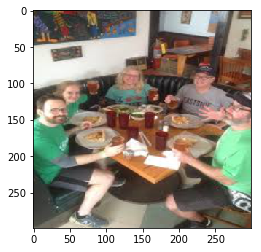

a group of people are sitting in a living room
a group of people sitting around a table with a large pizza .
a group of people standing around a table with a cake .
a group of people sitting around a table with a cake .
a group of people sitting around a table .
a man standing in front of a table with a laptop .
a group of people sitting around a table .
a group of people sitting around a table .
a group of people sitting around a table eating pizza .
a group of people sitting around a table .


In [168]:
!wget https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRddIEvpum69uxIXvk-muy94b4EYLCNZHHCQF0rNFzKlYPPVIa4 -O data/img.jpg
img = plt.imread('data/img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=3.)[1:-1]))

--2018-04-25 19:49:46--  http://ultimatefrisbeehq.com/wp-content/uploads/2015/02/frisbeedan1.jpg
Resolving ultimatefrisbeehq.com (ultimatefrisbeehq.com)... 50.62.117.1
Connecting to ultimatefrisbeehq.com (ultimatefrisbeehq.com)|50.62.117.1|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 97149 (95K) [image/jpeg]
Saving to: ‘data/img.jpg’

100%[======================================>] 97 149       248KB/s   in 0,4s   

2018-04-25 19:49:47 (248 KB/s) - ‘data/img.jpg’ saved [97149/97149]



/home/use/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


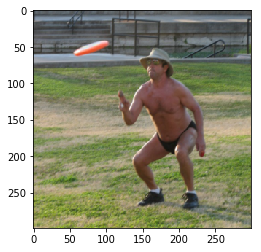

a man is playing a game of frisbee .
a man and woman playing a game of frisbee .
a man and a woman playing a game of frisbee .
a man in a field with a frisbee in his hand .
a woman is playing a game of frisbee .
a man is playing a game of frisbee .
a man is playing a game of frisbee .
a man and a woman playing a game of frisbee .
a man is playing a game of frisbee .
a woman is playing a game of frisbee .


In [170]:
!wget http://ultimatefrisbeehq.com/wp-content/uploads/2015/02/frisbeedan1.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

--2018-04-25 20:04:23--  https://ak3.picdn.net/shutterstock/videos/5936003/thumb/1.jpg
Resolving ak3.picdn.net (ak3.picdn.net)... 2.23.110.206
Connecting to ak3.picdn.net (ak3.picdn.net)|2.23.110.206|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36549 (36K) [image/jpeg]
Saving to: ‘data/img.jpg’

100%[======================================>] 36 549      --.-K/s   in 0,02s   

2018-04-25 20:04:23 (1,64 MB/s) - ‘data/img.jpg’ saved [36549/36549]



/home/use/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


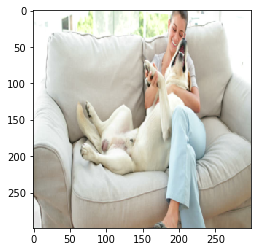

a woman laying on a bed with a dog .
a woman sitting on a couch with a dog .
a woman holding a baby in a crib with a dog .
a woman laying on a bed with a dog .
a woman laying on a bed with a dog .
a woman sitting on a bed with a dog .
a woman sitting on a couch holding a wii controller .
a woman laying on a bed with a dog .
a woman laying on a bed with a dog .
a woman laying on a bed with a dog .


In [212]:
!wget https://ak3.picdn.net/shutterstock/videos/5936003/thumb/1.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.0)[1:-1]))

--2018-04-25 20:06:30--  http://www.sportsonearth.com/assets/images/4/5/2/80690452/cuts/450766856_01k6iims_rbf74tvu.jpg
Resolving www.sportsonearth.com (www.sportsonearth.com)... 164.215.74.185, 164.215.74.184
Connecting to www.sportsonearth.com (www.sportsonearth.com)|164.215.74.185|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 56556 (55K) [image/jpeg]
Saving to: ‘data/img.jpg’

100%[======================================>] 56 556      --.-K/s   in 0,005s  

2018-04-25 20:06:30 (11,3 MB/s) - ‘data/img.jpg’ saved [56556/56556]



/home/use/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


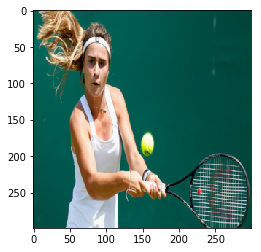

a woman is playing tennis on a tennis court .
a woman holding a tennis racket in her hand .
a woman holding a tennis racket in her hand .
a woman is holding a tennis racket in her hand .
a woman is holding a tennis racket in her hand .
a man is playing tennis on a tennis court .
a woman is holding a tennis racket in her hand .
a woman is holding a tennis racket in her hand .
a woman holding a tennis racket in her hand .
a woman is holding a tennis racket in her hand .


In [215]:
!wget http://www.sportsonearth.com/assets/images/4/5/2/80690452/cuts/450766856_01k6iims_rbf74tvu.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=10.)[1:-1]))

--2018-04-25 20:10:19--  https://www.hbw.com/sites/default/files/styles/ibc_1k/public/ibc/p/Serinus_flaviventris_1Botsw.jpg
Resolving www.hbw.com (www.hbw.com)... 78.47.240.78
Connecting to www.hbw.com (www.hbw.com)|78.47.240.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21750 (21K) [image/jpeg]
Saving to: ‘data/img.jpg’

100%[======================================>] 21 750      --.-K/s   in 0s      

2018-04-25 20:10:19 (46,4 MB/s) - ‘data/img.jpg’ saved [21750/21750]



/home/use/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


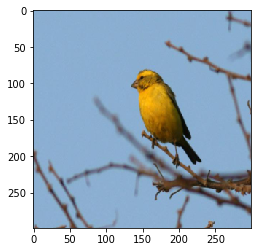

a bird is perched on a branch in a tree .
a bird is perched on a branch in a tree .
a bird is perched on a branch in a tree .
a bird is perched on a branch in a tree .
a bird that is perched on a branch .
a bird is perched on a branch in a tree .
a bird is perched on a branch in a tree .
a bird is perched on a branch in a tree .
a bird is perched on a branch in a tree .
a bird is perched on a branch in a tree .


In [227]:
!wget https://www.hbw.com/sites/default/files/styles/ibc_1k/public/ibc/p/Serinus_flaviventris_1Botsw.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

--2018-04-25 20:11:26--  https://media-cdn.tripadvisor.com/media/photo-s/01/06/60/4f/giraffe-at-buffalo-zoo.jpg
Resolving media-cdn.tripadvisor.com (media-cdn.tripadvisor.com)... 68.232.34.11
Connecting to media-cdn.tripadvisor.com (media-cdn.tripadvisor.com)|68.232.34.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87236 (85K) [image/jpeg]
Saving to: ‘data/img.jpg’

100%[======================================>] 87 236      --.-K/s   in 0,03s   

2018-04-25 20:11:26 (2,82 MB/s) - ‘data/img.jpg’ saved [87236/87236]



/home/use/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


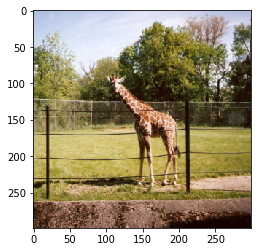

a giraffe standing next to a tree in a field .
a giraffe is standing in a field with trees in the background .
a giraffe standing in a field with trees in the background .
a giraffe standing in a field with trees in the background .
a giraffe standing in a field with trees in the background
a giraffe standing next to a fence in a field .
a giraffe is standing in a field of grass .
a giraffe is standing in a field of grass .
a giraffe standing next to a tree in a field .
a giraffe is standing in a field of grass .


In [231]:
!wget https://media-cdn.tripadvisor.com/media/photo-s/01/06/60/4f/giraffe-at-buffalo-zoo.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

--2018-04-25 20:18:52--  http://www.urlpagerank.com/wp-content/uploads/2017/01/1000-ideas-about-martini-centerpiece-on-pinterest-glass-wine-glass-vase-flower-arrangement.jpg
Resolving www.urlpagerank.com (www.urlpagerank.com)... 198.54.114.134
Connecting to www.urlpagerank.com (www.urlpagerank.com)|198.54.114.134|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24923 (24K) [image/jpeg]
Saving to: ‘data/img.jpg’

100%[======================================>] 24 923       122KB/s   in 0,2s   

2018-04-25 20:18:53 (122 KB/s) - ‘data/img.jpg’ saved [24923/24923]



/home/use/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


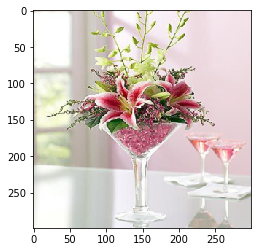

a vase filled with lots of flowers and a glass vase .
a vase with a bunch of flowers in it .
a vase with a flower pot and a bowl of flowers .
a vase filled with lots of flowers and a glass vase .
a vase filled with lots of flowers and a glass of wine .
a vase filled with lots of flowers and a glass of wine .
a vase filled with purple flowers sitting on top of a table .
a vase filled with lots of flowers and a glass vase .
a vase filled with lots of flowers and a glass vase .
a vase filled with lots of flowers and a glass vase .


In [246]:
!wget http://www.urlpagerank.com/wp-content/uploads/2017/01/1000-ideas-about-martini-centerpiece-on-pinterest-glass-wine-glass-vase-flower-arrangement.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

--2018-04-25 20:20:33--  https://ak3.picdn.net/shutterstock/videos/4460303/thumb/1.jpg
Resolving ak3.picdn.net (ak3.picdn.net)... 2.23.110.206
Connecting to ak3.picdn.net (ak3.picdn.net)|2.23.110.206|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33509 (33K) [image/jpeg]
Saving to: ‘data/img.jpg’

100%[======================================>] 33 509      --.-K/s   in 0,02s   

2018-04-25 20:20:33 (1,50 MB/s) - ‘data/img.jpg’ saved [33509/33509]



/home/use/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


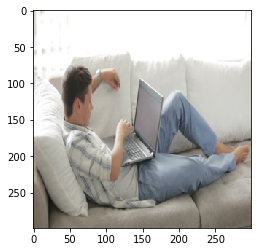

a man sitting on a couch with a laptop .
a man sitting on a bed with a laptop .
a man and a woman sitting on a bed .
a man sitting on a bed with a laptop .
a man sitting on a bed with a laptop .
a man sitting on a bed with a laptop .
a man sitting on a bed with a laptop .
a man sitting on a bed with a laptop .
a man sitting on a bed with a laptop .
a man sitting on a bed with a laptop .


In [251]:
!wget https://ak3.picdn.net/shutterstock/videos/4460303/thumb/1.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=8.)[1:-1]))

### Now what?

Your model produces some captions but you still strive to improve it? You're damn right to do so. Here are some ideas that go beyond simply "stacking more layers". The options are listed easiest to hardest.

##### Subword level captioning
In the base version, we replace all rare words with UNKs which throws away a lot of information and reduces quality. A better way to deal with vocabulary size problem would be to use Byte-Pair Encoding

* BPE implementation you can use: [github_repo](https://github.com/rsennrich/subword-nmt). 
* Theory: https://arxiv.org/abs/1508.07909
* It was originally built for machine translation, but it should work with captioning just as well.

##### Attention
You can build better and more interpretable captioning model with attention.
* How it works: https://distill.pub/2016/augmented-rnns/
* One way of doing this in captioning: https://arxiv.org/abs/1502.03044
* You will have to create a dataset for attention with [this notebook](https://gist.github.com/justheuristic/11fd01f9c12c0bf960499580d104130b).

#### Reinforcement learning
* After your model has been pre-trained in a teacher forced way, you can tune for captioning-speific models like CIDEr.
* Tutorial on RL for sequence models: [practical_rl week8](https://github.com/yandexdataschool/Practical_RL/tree/master/week8_scst)
* Theory: https://arxiv.org/abs/1612.00563